# Dataset Preparation - Splitting Month-by-Month Datasets


In [2]:
# packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from pathlib import Path

# Add project root to path for imports
project_root = Path(__file__).parent.parent if '__file__' in globals() else Path.cwd().parent
sys.path.append(str(project_root))
sys.path.append(str(project_root / 'features'))

# Import pipeline classes (fixed syntax - removed .py)
from trend_indicator_pipeline_pkg import TrendIndicatorPipeline, MomentumIndicatorPipeline, VolatilityIndicatorPipeline, CorrelationIndicatorPipeline, FractalDimensionPipeline

# Import configuration for adaptive paths
try:
    from config import config, ARCTIC_URI
    print(f"Using adaptive configuration. Arctic URI: {ARCTIC_URI}")
except ImportError:
    print("Config not found, using fallback paths")
    ARCTIC_URI = f"lmdb://{project_root / 'arctic_store'}"

from arcticdb.version_store.helper import ArcticMemoryConfig
from arcticdb import Arctic

Using adaptive configuration. Arctic URI: lmdb://E:\Coding\Crypto_Research\arctic_store


In [3]:
# Load files using adaptive paths
data_file = project_root / 'data' / 'BTCUSD_2023-1min_ML.csv'
df_1min = pd.read_csv(data_file)
df_1min['Timestamp'] = pd.to_datetime(df_1min['Timestamp'])
df_1min.set_index('Timestamp', inplace=True)

# Use adaptive DB path from config
try:
    DB_PATH = config.arctic_db_path
    print(f"Using adaptive DB path: {DB_PATH}")
except NameError:
    # Fallback if config not loaded
    DB_PATH = str(project_root / 'arctic_store')
    print(f"Using fallback DB path: {DB_PATH}")

print(f"Data file path: {data_file}")
print(f"Data shape: {df_1min.shape}")
print(f"Date range: {df_1min.index.min()} to {df_1min.index.max()}")

Using adaptive DB path: E:\Coding\Crypto_Research\arctic_store
Data file path: e:\Coding\Crypto_Research\data\BTCUSD_2023-1min_ML.csv
Data shape: (484640, 25)
Date range: 2023-01-01 14:00:00 to 2023-12-31 14:27:00


In [4]:
# Split dataset into monthly chunks
monthly_data = {}
monthly_stats = []

# Group by year-month
for year_month, group in df_1min.groupby(df_1min.index.to_period('M')):
    month_str = str(year_month)
    monthly_data[month_str] = group.copy()
    
    # Collect statistics for each month
    stats = {
        'month': month_str,
        'start_date': group.index.min(),
        'end_date': group.index.max(),
        'total_records': len(group),
        'days_covered': (group.index.max() - group.index.min()).days + 1,
        'missing_minutes': 0  # Will calculate if needed
    }
    monthly_stats.append(stats)
    
    print(f"{month_str}: {len(group):,} records from {group.index.min()} to {group.index.max()}")

print(f"\nTotal months created: {len(monthly_data)}")
print(f"Original dataset size: {len(df_1min):,} records")
print(f"Sum of monthly datasets: {sum(len(data) for data in monthly_data.values()):,} records")

2023-01: 38,013 records from 2023-01-01 14:00:00 to 2023-01-31 23:59:00
2023-02: 38,508 records from 2023-02-01 00:00:00 to 2023-02-28 23:59:00
2023-03: 43,027 records from 2023-03-01 00:00:00 to 2023-03-31 23:59:00
2023-04: 40,858 records from 2023-04-01 00:00:00 to 2023-04-30 23:59:00
2023-05: 39,593 records from 2023-05-01 00:00:00 to 2023-05-31 23:59:00
2023-06: 40,938 records from 2023-06-01 00:00:00 to 2023-06-30 23:59:00
2023-07: 36,111 records from 2023-07-01 00:00:00 to 2023-07-31 23:47:00
2023-08: 38,461 records from 2023-08-01 00:00:00 to 2023-08-31 23:57:00
2023-09: 42,211 records from 2023-09-01 00:00:00 to 2023-09-30 23:59:00
2023-10: 44,316 records from 2023-10-01 00:00:00 to 2023-10-31 23:59:00
2023-11: 41,363 records from 2023-11-01 00:00:00 to 2023-11-30 23:59:00
2023-12: 41,241 records from 2023-12-01 00:00:00 to 2023-12-31 14:27:00

Total months created: 12
Original dataset size: 484,640 records
Sum of monthly datasets: 484,640 records


In [5]:
# Create a summary DataFrame of monthly statistics
monthly_summary_df = pd.DataFrame(monthly_stats)
monthly_summary_df['start_date'] = pd.to_datetime(monthly_summary_df['start_date'])
monthly_summary_df['end_date'] = pd.to_datetime(monthly_summary_df['end_date'])

print("Monthly Dataset Summary:")
print("=" * 80)
print(monthly_summary_df.to_string(index=False))
print("=" * 80)

# Calculate some additional statistics
total_records = monthly_summary_df['total_records'].sum()
avg_records_per_month = monthly_summary_df['total_records'].mean()
min_records_month = monthly_summary_df.loc[monthly_summary_df['total_records'].idxmin(), 'month']
max_records_month = monthly_summary_df.loc[monthly_summary_df['total_records'].idxmax(), 'month']

print(f"\nSummary Statistics:")
print(f"Total records across all months: {total_records:,}")
print(f"Average records per month: {avg_records_per_month:,.0f}")
print(f"Month with fewest records: {min_records_month} ({monthly_summary_df['total_records'].min():,} records)")
print(f"Month with most records: {max_records_month} ({monthly_summary_df['total_records'].max():,} records)")

Monthly Dataset Summary:
  month          start_date            end_date  total_records  days_covered  missing_minutes
2023-01 2023-01-01 14:00:00 2023-01-31 23:59:00          38013            31                0
2023-02 2023-02-01 00:00:00 2023-02-28 23:59:00          38508            28                0
2023-03 2023-03-01 00:00:00 2023-03-31 23:59:00          43027            31                0
2023-04 2023-04-01 00:00:00 2023-04-30 23:59:00          40858            30                0
2023-05 2023-05-01 00:00:00 2023-05-31 23:59:00          39593            31                0
2023-06 2023-06-01 00:00:00 2023-06-30 23:59:00          40938            30                0
2023-07 2023-07-01 00:00:00 2023-07-31 23:47:00          36111            31                0
2023-08 2023-08-01 00:00:00 2023-08-31 23:57:00          38461            31                0
2023-09 2023-09-01 00:00:00 2023-09-30 23:59:00          42211            30                0
2023-10 2023-10-01 00:00:00 2023-10

In [6]:
# Save monthly datasets to CSV files
monthly_output_dir = project_root / 'data' / 'monthly'
monthly_output_dir.mkdir(exist_ok=True)

print(f"Saving monthly datasets to: {monthly_output_dir}")
print("=" * 60)

saved_files = []
for month_str, month_data in monthly_data.items():
    # Create filename
    filename = f"BTCUSD_1min_{month_str.replace('-', '_')}.csv"
    filepath = monthly_output_dir / filename
    
    # Save to CSV
    month_data.to_csv(filepath)
    saved_files.append(filepath)
    
    print(f"Saved {month_str}: {filename} ({len(month_data):,} records)")

print(f"\nSuccessfully saved {len(saved_files)} monthly files to {monthly_output_dir}")

# Also save the monthly summary
summary_filepath = monthly_output_dir / 'monthly_summary.csv'
monthly_summary_df.to_csv(summary_filepath, index=False)
print(f"Saved summary: {summary_filepath.name}")

Saving monthly datasets to: e:\Coding\Crypto_Research\data\monthly
Saved 2023-01: BTCUSD_1min_2023_01.csv (38,013 records)
Saved 2023-02: BTCUSD_1min_2023_02.csv (38,508 records)
Saved 2023-03: BTCUSD_1min_2023_03.csv (43,027 records)
Saved 2023-04: BTCUSD_1min_2023_04.csv (40,858 records)
Saved 2023-05: BTCUSD_1min_2023_05.csv (39,593 records)
Saved 2023-06: BTCUSD_1min_2023_06.csv (40,938 records)
Saved 2023-07: BTCUSD_1min_2023_07.csv (36,111 records)
Saved 2023-08: BTCUSD_1min_2023_08.csv (38,461 records)
Saved 2023-09: BTCUSD_1min_2023_09.csv (42,211 records)
Saved 2023-10: BTCUSD_1min_2023_10.csv (44,316 records)
Saved 2023-11: BTCUSD_1min_2023_11.csv (41,363 records)
Saved 2023-12: BTCUSD_1min_2023_12.csv (41,241 records)

Successfully saved 12 monthly files to e:\Coding\Crypto_Research\data\monthly
Saved summary: monthly_summary.csv


In [ ]:
# Optional: Save monthly datasets to ArcticDB for efficient retrieval
import warnings
warnings.filterwarnings('ignore')

print("Saving monthly datasets to ArcticDB...")
print("=" * 50)

# Initialize Arctic connection
arctic = Arctic(ARCTIC_URI)

# Create library for monthly data if it doesn't exist
lib_name = 'monthly_btc_data'
if lib_name not in arctic.list_libraries():
    arctic.create_library(lib_name)
library = arctic[lib_name]

# Save each month to ArcticDB
for month_str, month_data in monthly_data.items():
    symbol_name = f"BTCUSD_1min_{month_str.replace('-', '_')}"
    library.write(symbol_name, month_data)
    print(f"Saved to ArcticDB: {symbol_name}")

# Also save the summary
library.write('monthly_summary', monthly_summary_df)
print(f"Saved to ArcticDB: monthly_summary")

print(f"\nSuccessfully saved {len(monthly_data)} monthly datasets + summary to ArcticDB library '{lib_name}'")

# List all symbols in the library to verify
symbols = library.list_symbols()
print(f"Total symbols in ArcticDB library: {len(symbols)}")
print("Symbols:", sorted(symbols))

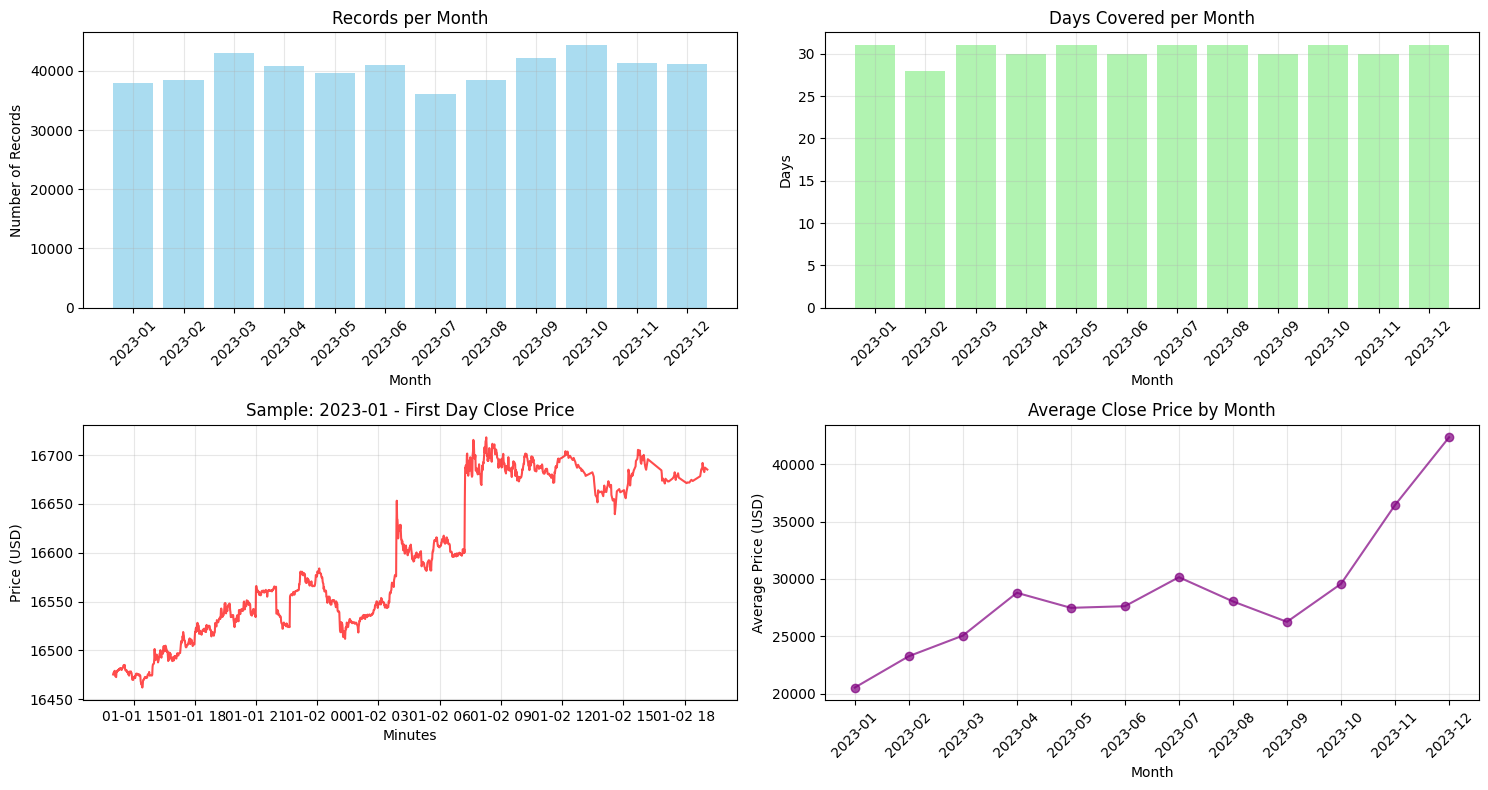


Monthly splitting completed successfully!
✅ Created 12 monthly datasets
✅ Saved 12 CSV files to e:\Coding\Crypto_Research\data\monthly


NameError: name 'symbols' is not defined

In [7]:
# Visualization: Monthly data distribution
plt.figure(figsize=(15, 8))

# Plot 1: Records per month
plt.subplot(2, 2, 1)
plt.bar(range(len(monthly_summary_df)), monthly_summary_df['total_records'], color='skyblue', alpha=0.7)
plt.title('Records per Month')
plt.xlabel('Month')
plt.ylabel('Number of Records')
plt.xticks(range(len(monthly_summary_df)), monthly_summary_df['month'], rotation=45)
plt.grid(True, alpha=0.3)

# Plot 2: Days covered per month
plt.subplot(2, 2, 2)
plt.bar(range(len(monthly_summary_df)), monthly_summary_df['days_covered'], color='lightgreen', alpha=0.7)
plt.title('Days Covered per Month')
plt.xlabel('Month')
plt.ylabel('Days')
plt.xticks(range(len(monthly_summary_df)), monthly_summary_df['month'], rotation=45)
plt.grid(True, alpha=0.3)

# Plot 3: Sample of first month data
plt.subplot(2, 2, 3)
first_month = list(monthly_data.keys())[0]
sample_data = monthly_data[first_month]['Close'].iloc[:1440]  # First day
plt.plot(sample_data, color='red', alpha=0.7)
plt.title(f'Sample: {first_month} - First Day Close Price')
plt.xlabel('Minutes')
plt.ylabel('Price (USD)')
plt.grid(True, alpha=0.3)

# Plot 4: Monthly average close prices
plt.subplot(2, 2, 4)
monthly_avg_prices = [data['Close'].mean() for data in monthly_data.values()]
plt.plot(range(len(monthly_avg_prices)), monthly_avg_prices, 'o-', color='purple', alpha=0.7)
plt.title('Average Close Price by Month')
plt.xlabel('Month')
plt.ylabel('Average Price (USD)')
plt.xticks(range(len(monthly_summary_df)), monthly_summary_df['month'], rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nMonthly splitting completed successfully!")
print(f"✅ Created {len(monthly_data)} monthly datasets")
print(f"✅ Saved {len(saved_files)} CSV files to {monthly_output_dir}")
print(f"✅ Saved {len(symbols)} datasets to ArcticDB library '{lib_name}'")